In [83]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as md
import nglview as ng

In [84]:
u1 = md.Universe('../Rama-Crystal-1/NPT/simfiles/init.gro')
u2 = md.Universe('../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro')

In [85]:
ng.show_mdanalysis(u1, gui=True)

/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget()

In [86]:
ng.show_mdanalysis(u2, gui=True)

/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget()

In [69]:
crystal_waters = u1.select_atoms('resname HOH and name OW')

In [70]:
water_coords = crystal_waters.positions

In [71]:
waters2 = u2.select_atoms('resname SOL')

In [72]:
waters2

<AtomGroup with 3477 atoms>

In [102]:
crystal_waters

<AtomGroup with 376 atoms>

In [73]:
that_water1 = u1.select_atoms('resname HOH and resid 518 and name OW')

In [74]:
this_water2 = u2.select_atoms('resname SOL and resid 631 and name OW')

In [75]:
this_water2.positions

array([[ 29.17    , -11.280001,   8.7     ]], dtype=float32)

In [76]:
that_water1.positions

array([[18.09     , -7.0499997, 25.89     ],
       [50.75     , 12.67     , 25.89     ],
       [29.17     , -7.0499997,  8.7      ],
       [-3.48     , 12.67     ,  8.7      ]], dtype=float32)

In [77]:
crystal_water_coordinates = water_coords

In [78]:
water_coords

array([[21.189999  , 12.57      , -2.9699998 ],
       [ 2.73      ,  9.43      , -0.78000003],
       [ 5.84      ,  4.79      , 10.039999  ],
       ...,
       [-7.7200003 , 29.119999  , 36.55      ],
       [-0.96000004, 21.619999  , 19.119999  ],
       [ 4.44      , 51.39      , 25.02      ]], dtype=float32)

In [79]:
crystal_water_coordinates = water_coords - np.array([0.0, 4.23, 0.0]) 

In [80]:
crystal_water_coordinates

array([[21.18999863,  8.33999969, -2.96999979],
       [ 2.73000002,  5.20000031, -0.78000003],
       [ 5.84000015,  0.55999996, 10.03999901],
       ...,
       [-7.72000027, 24.88999893, 36.54999924],
       [-0.96000004, 17.38999893, 19.11999893],
       [ 4.44000006, 47.15999939, 25.02000046]])

In [82]:
crystal_water_coordinates.shape

(376, 3)

In [138]:
u_emin = md.Universe('../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro','../Rama-Crystal-1/NPT/energyMinRun/traj.trr')

< Timestep 0 with unit cell dimensions [ 65.3      39.45     39.01001  90.      117.54004  90.     ] >


In [94]:
#d = np.linalg.norm(CA_atoms[i].position - CA_atoms[j].position)

waters = u_emin.select_atoms('resname SOL and name OW')
import numpy as np

In [121]:
crystal_waters_atomgroup = u2.select_atoms('resname LLLLL')
for i, coord in enumerate(crystal_water_coordinates):
    found = False
    for atom in u2.select_atoms('resname SOL and name OW'):
        if np.linalg.norm(atom.position - coord) < 0.3:
            crystal_waters_atomgroup += atom
            found = True
    if not found:
        print(coord, i)
print(crystal_waters_atomgroup.n_atoms)

[11.77000046 -4.01       -1.49000001] 40
[ 9.68999958 -2.0799999   5.36000013] 52
[46.14999771  2.33000042 35.43999863] 193
[31.42000008 17.17000153 38.40999985] 233
[ 6.11000013 19.38999893 22.52000046] 340
[12.98999977 39.70000031 23.15000153] 347
370


In [132]:
crystal_waters.atoms[40]

<Atom 6005: OW of type O of resname HOH, resid 541 and segid SYSTEM>

In [137]:
crystal_waters_atomgroup

<AtomGroup with 370 atoms>

In [144]:
crystal_waters_selection = u_emin.select_atoms('resname HUI')
for atom in crystal_waters_atomgroup:
    crystal_waters_selection += u_emin.atoms[atom.index] 
print(crystal_waters_selection.n_atoms)    

370


In [239]:
fixed_coordinates = crystal_waters_selection.positions.copy()

In [120]:
u2.atoms[6994].position, u2.atoms[6997].position, u2.atoms[7000].position, u2.atoms[7003].position, u2.atoms[7006].position, u2.atoms[7009].position

(array([ 9.73,  8.9 , 15.72], dtype=float32),
 array([ 4.61, 12.66, 17.27], dtype=float32),
 array([5.39      , 0.64000005, 5.1200004 ], dtype=float32),
 array([15.92    , 16.289999, 16.25    ], dtype=float32),
 array([ 9.150001 ,  0.89     , 14.0199995], dtype=float32),
 array([ 7.0499997, 10.5      ,  3.68     ], dtype=float32))

In [133]:
u_berendsen = md.Universe('../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro','../Rama-Crystal-1/NPT/BerendsenRun/traj.xtc')
ng.show_mdanalysis(u_berendsen, gui=True)

/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget(count=1001)

In [153]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

[0.8756756756756757, 0.8378378378378378, 0.8405405405405405, 0.7810810810810811, 0.8135135135135135, 0.8, 0.7810810810810811, 0.7864864864864864, 0.7918918918918919, 0.7810810810810811, 0.772972972972973, 0.7864864864864864, 0.7567567567567568, 0.7891891891891892, 0.7594594594594595, 0.7810810810810811, 0.7810810810810811, 0.772972972972973, 0.7594594594594595, 0.772972972972973, 0.7486486486486487, 0.8027027027027027, 0.7756756756756756, 0.7756756756756756, 0.7405405405405405, 0.7513513513513513, 0.7702702702702703, 0.7567567567567568, 0.7594594594594595, 0.7351351351351352, 0.7216216216216216, 0.7405405405405405, 0.7567567567567568, 0.7756756756756756, 0.7648648648648648, 0.7594594594594595, 0.7594594594594595, 0.7702702702702703, 0.772972972972973, 0.7621621621621621, 0.7486486486486487, 0.7513513513513513, 0.7432432432432432, 0.7351351351351352, 0.7702702702702703, 0.7810810810810811, 0.7513513513513513, 0.7216216216216216, 0.7486486486486487, 0.7513513513513513, 0.7486486486486487

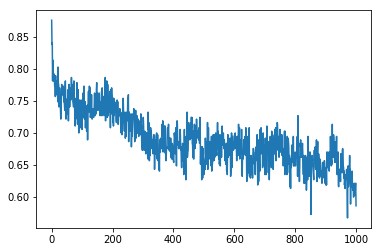

In [154]:
percent = []
for ts in u_berendsen.trajectory[:2]:
    counter = 0
    for crystal_coord in fixed_coordinates:
        for oxygen in u_berendsen.select_atoms('resname SOL and name OW'):
            if np.linalg.norm(crystal_coord - oxygen.position) < 2.0:
                counter += 1
                break
    counter /= 370.
    percent.append(counter)
print(percent)
plt.plot(percent)
plt.show()

In [164]:
from MDAnalysis.analysis.distances import distance_array
box1 = [ 65.3, 39.45, 39.01,  90., 117.54004,  90.]

In [240]:
fixed_coordinates[0]

array([ 2.9727626,  8.306053 , 31.776787 ], dtype=float32)

In [284]:
cutoff = 2.5

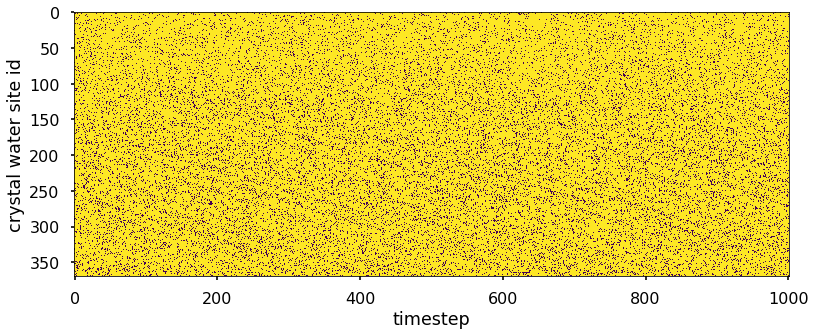

In [290]:
u_berendsen = md.Universe('../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro','../Rama-Crystal-1/NPT/BerendsenRun/traj.xtc')
occupancy = np.zeros((1001, 370))
#result = np.empty((370, 1159))
oxygens = u_berendsen.select_atoms('resname SOL and name OW')
counter = 0
for ts in u_berendsen.trajectory:
    box = ts.dimensions
    d = distance_array(fixed_coordinates.reshape((-1, 3)), oxygens.positions, box=box, result=None, backend='OpenMP')
    mindist = np.min(d, axis=1)
    occupancy[counter] = mindist
    counter += 1
plt.imshow(occupancy.reshape((370,-1)) < cutoff)
plt.xlabel('timestep')
plt.ylabel('crystal water site id')
plt.show()

In [286]:
av_percent = np.sum(occupancy < cutoff, axis = 0) / 1001.

In [287]:
percent = np.sum(occupancy < cutoff, axis = 1) / 370.

Text(0, 0.5, 'crystal water sites occupancy')

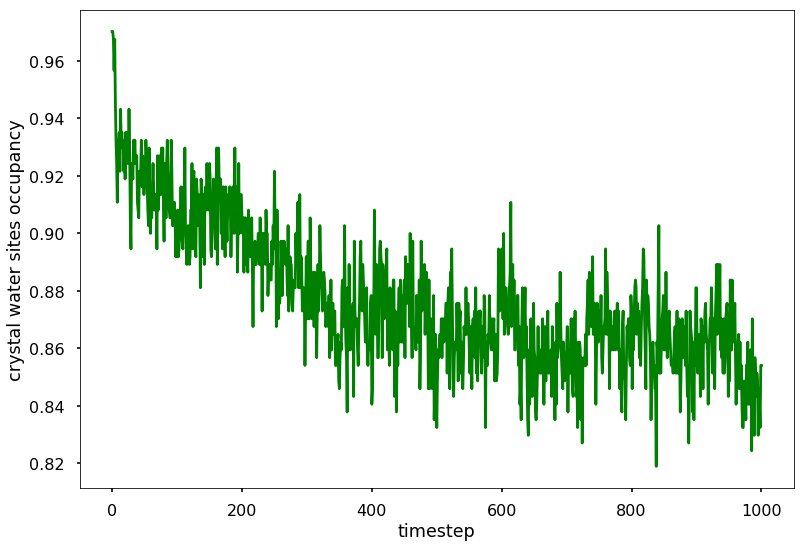

In [288]:
plt.plot(percent, 'g-')
plt.xlabel('timestep')
plt.ylabel('crystal water sites occupancy')

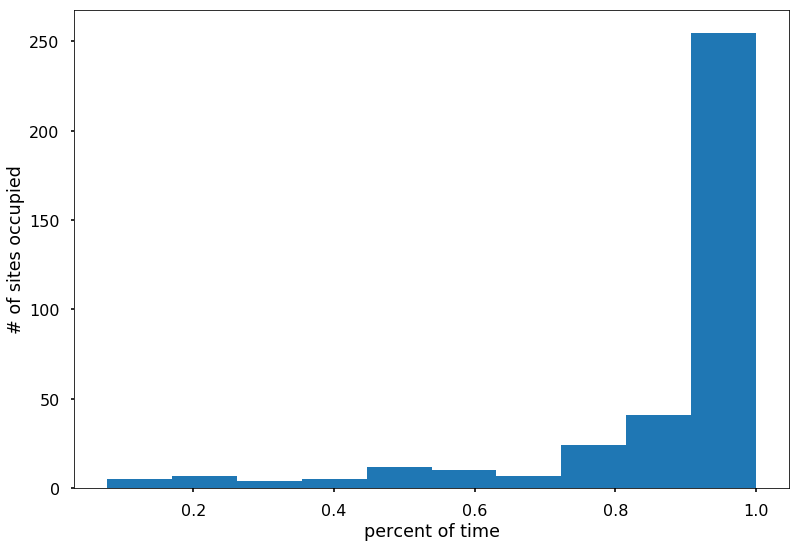

In [291]:
plt.hist(av_percent)
plt.ylabel('# of sites occupied')
plt.xlabel('percent of time')
plt.show()